# Conv-model with Feature Engineering for Uncertainty Prediction

## Import packages

In [1]:
import glob
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits

from tqdm import tqdm

from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer, plot_analysis_hist2d
from inverse_problem.nn_inversion.posthoc import open_spectrum_data, real_spectra, plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion.transforms import normalize_output, inverse_transformation

from inverse_problem.nn_inversion.model_pi_mlp_conv_up import PIMLPConvDistributionNet
from inverse_problem.nn_inversion import conv1d_transform_rescale, normalize_spectrum


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
from pathlib import Path

model_name = 'up_model'

current_time = str(datetime.now().strftime('%Y-%m-%d_%H-%M'))

save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../up_model_2022-01-27_23-59/'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device.type)

cuda


## Dataset

In [3]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

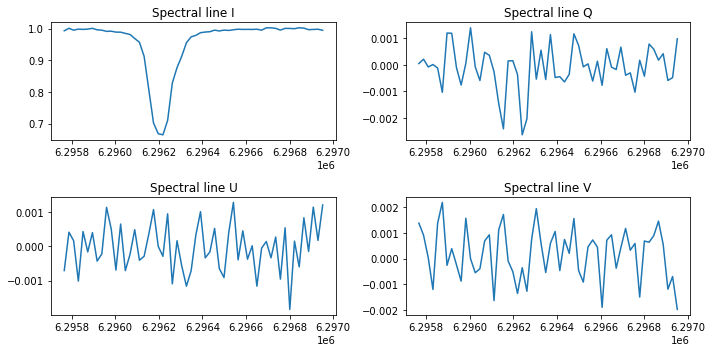

In [4]:
line_type = ['I', 'Q', 'U', 'V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
for i in range(4):
    ax[i // 2][i % 2].plot(line_arg, sample['X'][0][:, i])
    ax[i // 2][i % 2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight=True)
fig.set_facecolor('xkcd:white')

## Data Filtering

In [5]:
params = fits.open(filename)[0].data

In [6]:
def params_masked_rows(pars_arr):
    
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])

    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)

In [7]:
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

## Dataloader

In [10]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = True, True

transform_name = "conv1d_transform_rescale"

batch_size = 128
num_workers = 1 if 'cuda' in device.type else 0

In [11]:
train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       batch_size=batch_size, num_workers=num_workers)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 19850, for validation: 2206


## Model

In [11]:
model = PIMLPConvDistributionNet(n_blocks=6, in_dim=(4, 64, 64, 128, 128, 256), out_dim=(64, 64, 128, 128, 256, 256),
                                 kernel_size=(3, 3, 3, 3, 3, 3), padding=(1, 1, 1, 1, 1, 1), activation='elu', 
                                 dropout=0.05, batch_norm=True, pool=(None, 'max', None, 'max', None, None), 
                                 hidden_dims=(100, 100), bottom_output=100, number_readout_layers=2, top_output=11)

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device);

## Model Training

In [19]:
def mdn_cost(mu, sigma, y):
    dist = torch.distributions.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

def fit_step(dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break

            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])

            optimizer.zero_grad()
            
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            
            loss = torch.stack(losses).mean()
            loss.backward()
            
            optimizer.step()

            train_loss += loss.item()
            train_it += 1

            if train_it % 10 == 0:
                pbar_outer.update(10)

        return train_loss / train_it


def eval_step(dataloader):
    model.eval()
    val_loss = 0.0
    val_it = 0

    for i, inputs in enumerate(dataloader):
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)

        with torch.no_grad():
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            
            loss = torch.stack(losses).mean()
            
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it


def save_model(path, epoch, loss):
    """
    Args:
        path (str): path to save model to
        epoch (int): optional
        loss (float): optional, validation loss
    Returns:
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + model_name + '_' f'ep{epoch}.pt')


def train(n_epoch, log_dir=None, path_to_save=None, max_steps=None):
    loss_history = []
    best_valid_loss = float('inf')

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=n_epoch, position=0, leave=True) as pbar_outer:
        for epoch in range(n_epoch):
            train_loss = fit_step(train_loader, max_steps)
            val_loss = eval_step(val_loader)
            loss_history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))

            if path_to_save:
                if val_loss < best_valid_loss:
                    best_valid_loss = val_loss
                    save_model(path_to_save, epoch, val_loss)

            with open(os.path.join(log_dir, 'history_' + model_name + '_' + current_time + '.txt'), 'w') as f:
                for i, item in enumerate(loss_history):
                    f.write(f"Train loss in epoch {i}: {item[0]: .4f}, val_loss: {item[1]:.4f}\n")

    return loss_history

In [20]:
num_epochs = 5

In [24]:
%%time

history = train(n_epoch=num_epochs,
                log_dir=save_path,
                path_to_save=save_path)

epoch:  20%|██        | 1/5 [1:03:58<4:15:53, 3838.33s/it]


Epoch 001 train_loss: -1.8696 val_loss -2.2468


epoch:  40%|████      | 2/5 [2:10:55<3:17:09, 3943.32s/it]


Epoch 002 train_loss: -2.3159 val_loss -2.3724


epoch:  60%|██████    | 3/5 [3:18:41<2:13:18, 3999.43s/it]


Epoch 003 train_loss: -2.4109 val_loss -2.4720


epoch:  80%|████████  | 4/5 [4:25:13<1:06:36, 3996.67s/it]


Epoch 004 train_loss: -2.4859 val_loss -2.5453


epoch: 100%|██████████| 5/5 [5:31:06<00:00, 3973.39s/it]  



Epoch 005 train_loss: -2.5432 val_loss -2.5785
CPU times: user 1h 59min 6s, sys: 60 s, total: 2h 6s
Wall time: 5h 31min 6s


## Model Analysis

Два варианта:
- Оценка понимания моделью симуляции спектров из референсных значений, полученных обращением реальных спектров
- Оценка качество работы на реальных спектрах

In [18]:
checkpoint_path = save_path + 'up_model_ep4.pt'
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

<All keys matched successfully>

### Реферер
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [19]:
# path_to_refer = '../data/hinode_source/20140926_170005.fits'
path_to_refer = '../data/reference.fits'

Можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные

In [20]:
refer_unnormalized, names = open_param_file(path_to_refer, normalize=False)
ref_unnormalized_2d = refer_unnormalized.reshape(-1, 11)

refer_shape = refer_unnormalized.shape

print('\n', refer_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 485, 11)


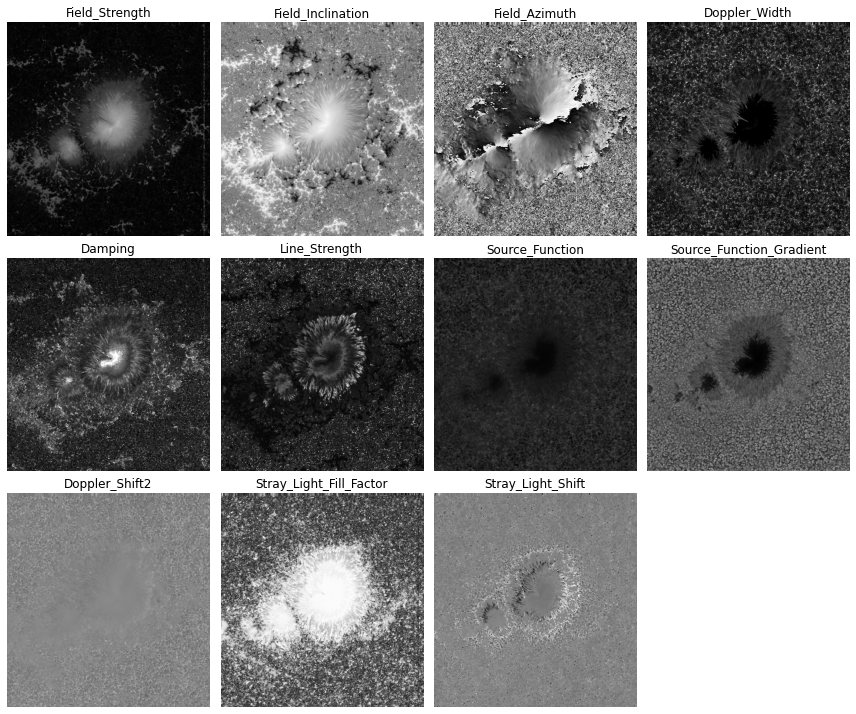

In [21]:
plot_params(refer_unnormalized, names=names)

In [22]:
ref_2d = normalize_output(ref_unnormalized_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation)

refer = ref_2d.reshape(refer_shape).copy()

### Refer Filtering

In [23]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(refer.shape)

masked_ref_unnormalized_2d = create_masked_array(ref_unnormalized_2d)
masked_ref_unnormalized = masked_ref_unnormalized_2d.reshape(refer.shape)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)

In [24]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB)

test_dataset = PregenSpectrumDataset(data_arr=masked_ref_unnormalized_2d,
                                     transform=transform)

CPU times: user 25.7 s, sys: 6.05 s, total: 31.7 s
Wall time: 32.3 s


In [25]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [26]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

CPU times: user 1min 33s, sys: 41.3 s, total: 2min 14s
Wall time: 1min 55s


In [27]:
predicted_mean = predicted[:, :11].detach().cpu().numpy()
predicted_sigma = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

In [37]:
compute_metrics(masked_ref_2d.data, predicted_mean,
                save_path=save_path+model_name+'.csv', 
                mask=masked_ref_2d.mask)

,r2,mse,mae
Field Strength,0.8482,0.0033,0.0407
Field Inclination,0.9061,0.0049,0.0522
Field Azimuth,0.6369,0.0404,0.1176
Doppler Width,0.7911,0.0122,0.0965
Damping,0.6213,0.0121,0.0830
Line Strength,0.2944,0.2506,0.4178
S_0,0.1832,0.0235,0.1372
S_1,0.6762,0.0075,0.0731
Doppler Shift,0.8212,0.0005,0.0130
Filling Factor,0.4458,0.1046,0.2584


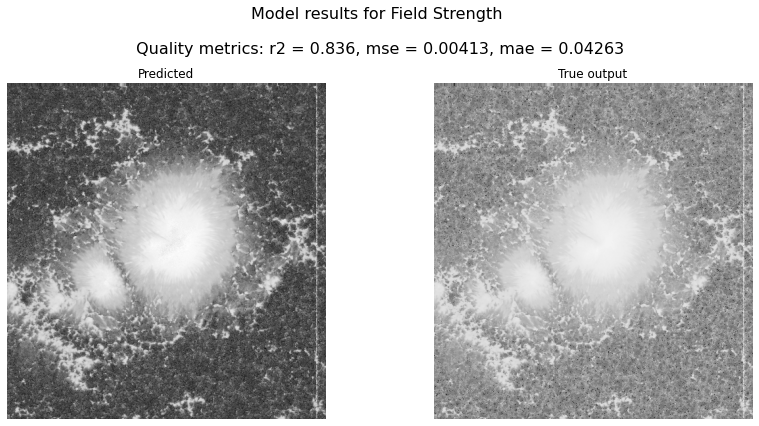

In [32]:
plot_pred_vs_refer(predicted_mean, refer, output_index=0)

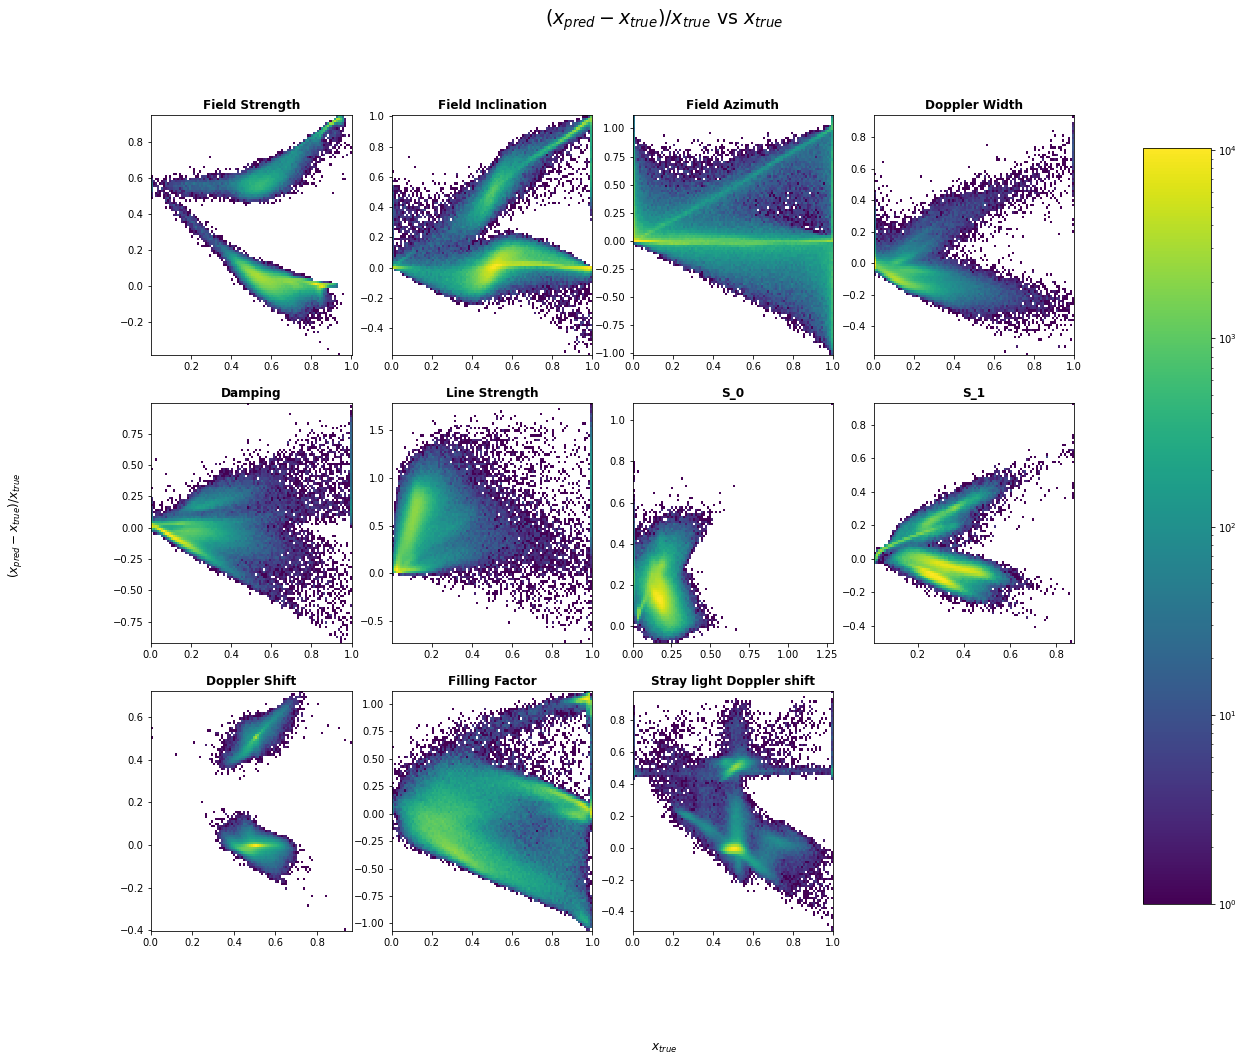

In [33]:
plot_analysis_hist2d(masked_ref_2d, predicted_mean, save_path=save_path+model_name+'_analysis_hist2d');

../inverse_problem/nn_inversion/posthoc.py:376: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(right=0.8)


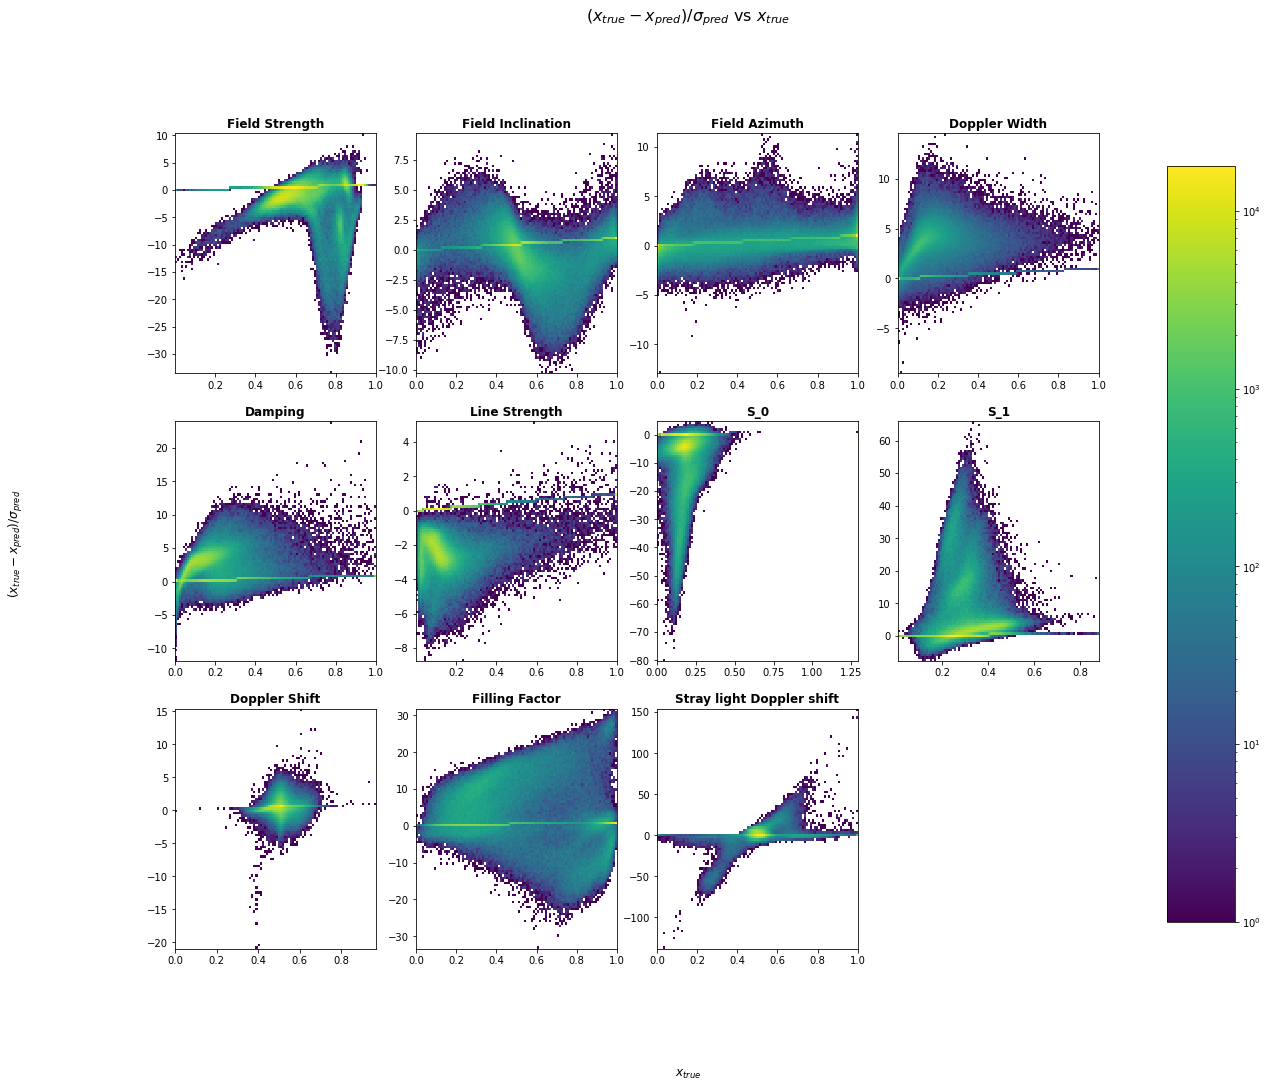

In [34]:
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_up

plot_analysis_hist2d_up(masked_ref_2d, predicted_mean, predicted_sigma, index=0, save_path=save_path+model_name+'_analysis_hist2d_up1');

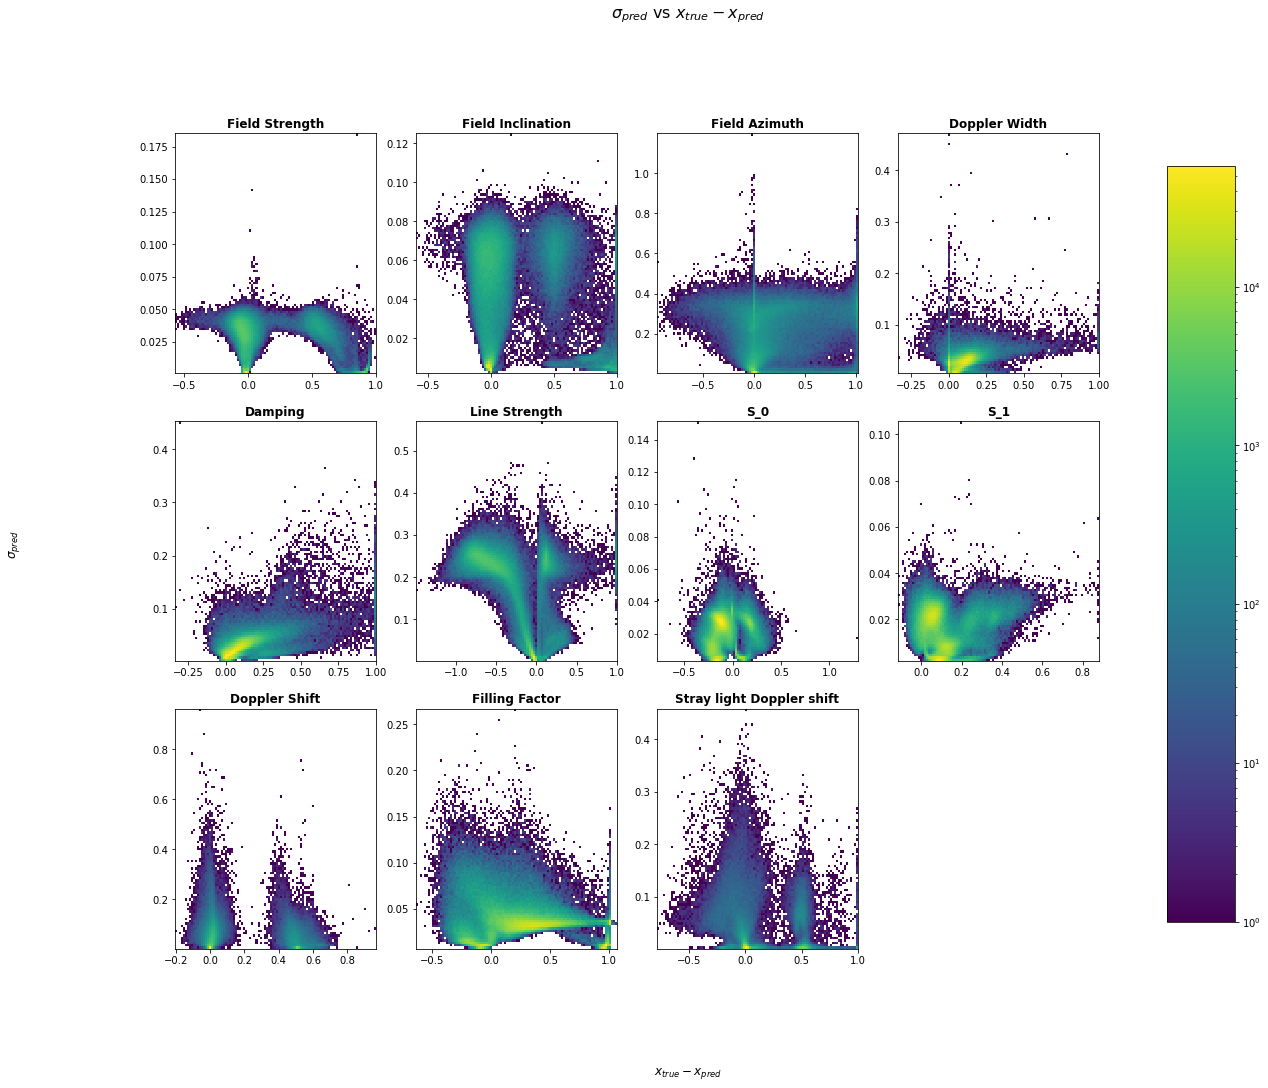

In [35]:
plot_analysis_hist2d_up(masked_ref_2d, predicted_mean, predicted_sigma, index=1, save_path=save_path+model_name+'_analysis_hist2d_up2');

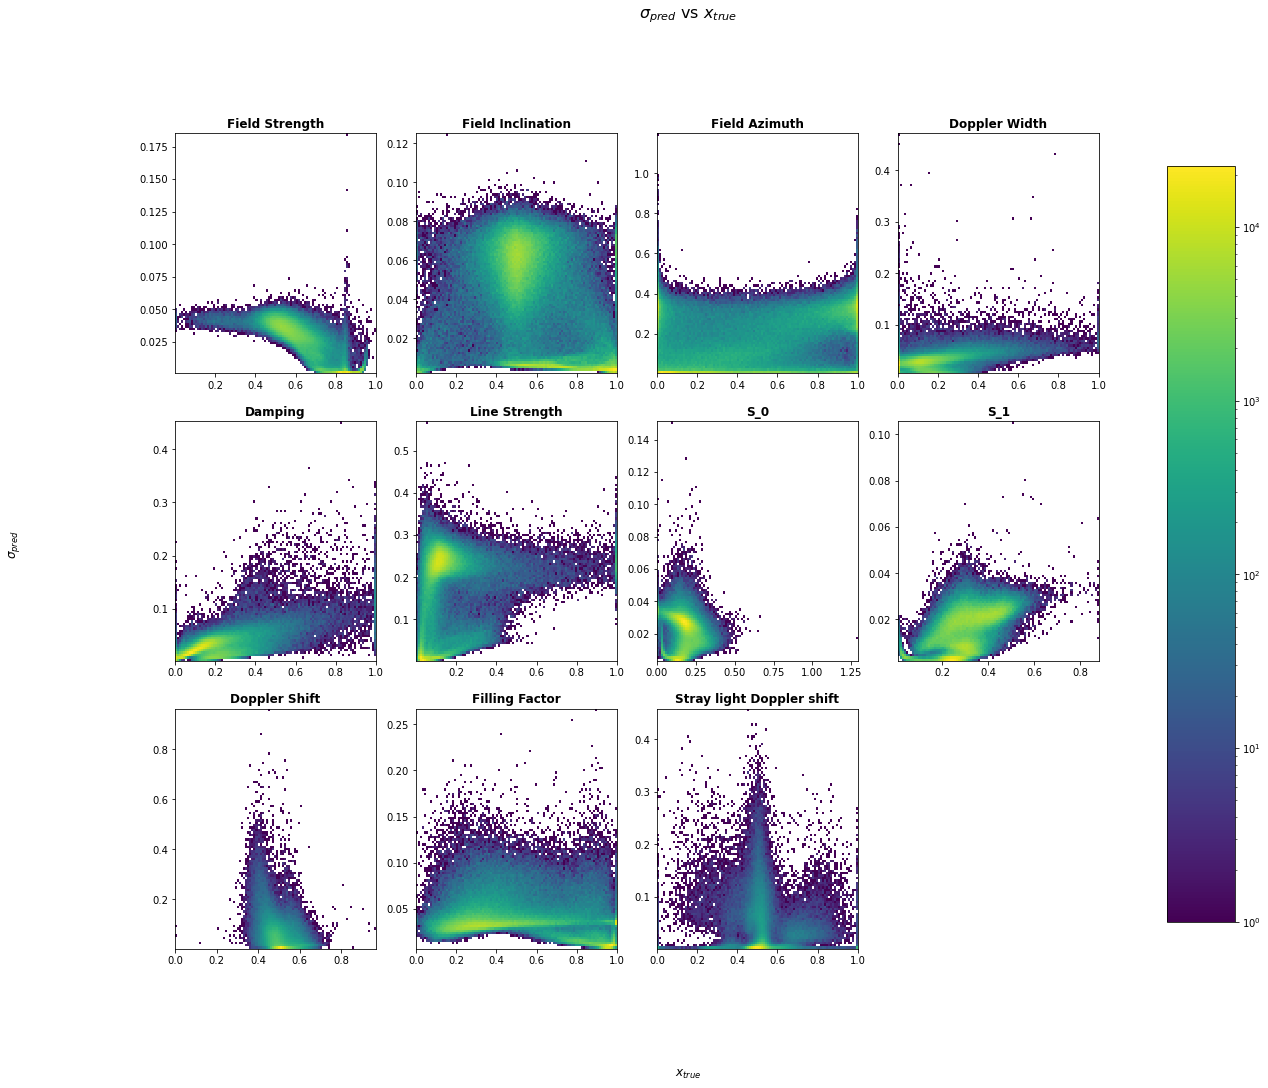

In [36]:
plot_analysis_hist2d_up(masked_ref_2d, predicted_mean, predicted_sigma, index=2, save_path=save_path+model_name+'_analysis_hist2d_up3');

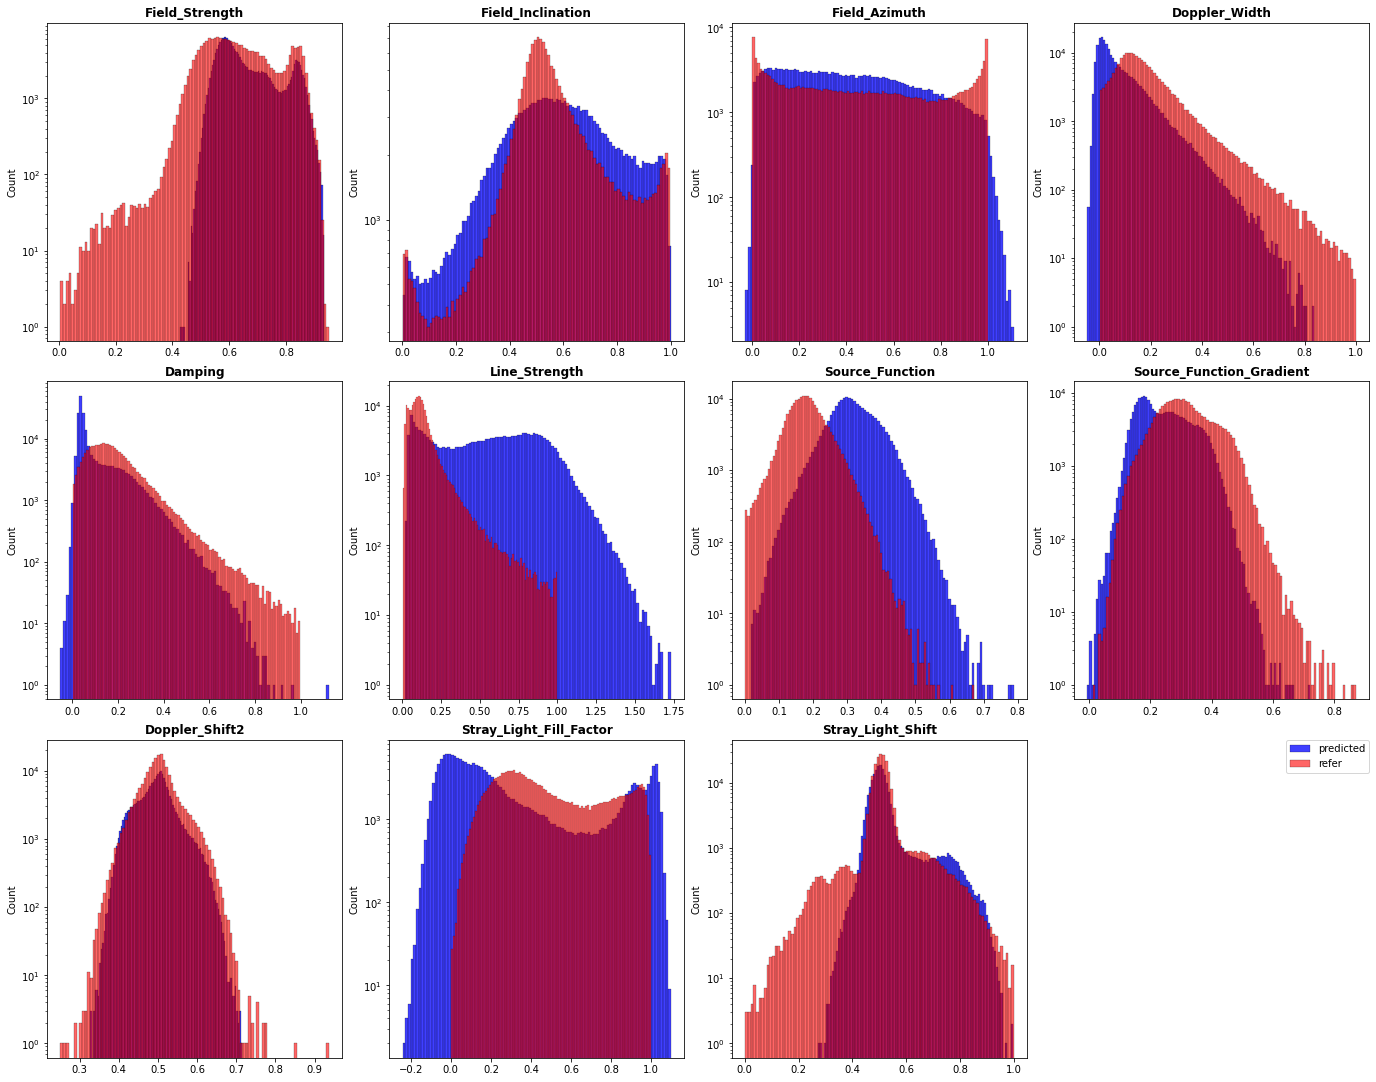

In [44]:
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison

mask = masked_ref_unnormalized.mask
plot_hist_params_comparison(predicted_mean.reshape(masked_ref.shape)[~mask], masked_ref_2d, names, plot_name='')

## Обратные преобразования параметров -- To Implement

## Проверка на реальных спектрах -- To Implement
Спектры лежат в отдельной папочке sp_..... (много папочек в папочках, оставила так же как и лежит на хиноде). Спектры получаются последовательным сканированием щели, и результаты каждой в своем фитсе, всего 873, внутри каждой щели 512 спектров.  

In [ ]:
path_to_folder = '../data/hinode_source'
path_to_refer = '../data/hinode_source/20140926_170005.fits'

# date as a list with year, month,day, hour 
date = ['2014', '09', '26', '17']

sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')

sp_path = os.path.join(sp_folder, date[0], date[1], date[2], 'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]

sp_lines = sorted(glob.glob(sp_path + '*.fits'))
print(f'Number of files: {len(sp_lines)}')

In [ ]:
# можно побегать индексами и посравнивать спектры
idx_0, idx_1 = 10, 10
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int = plot_model_spectrum(refer, names, idx_0, idx_1)

## Подготовка реальных спектров для модели

In [ ]:
def prepare_real_conv(sp_folder, date, factors=None, cont_scale=None, device=None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1, 56, 4), order='F'),
                                           factors=factors)
    
    norm_cont = cont / cont_scale
    norm_real_samples = np.reshape(norm_real_samples, (-1, 4, 56), order='F')
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x

In [ ]:
%%time

real_x = prepare_real_conv(sp_folder, date, factors=factors, cont_scale=cont_scale, device=device)

In [ ]:
# можно побегать индексами и посравнивать спектры
idx_0, idx_1 = 22, 794
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int = plot_model_spectrum(refer, names, idx_0, idx_1)

In [ ]:
#тоже можно побегать индексом и увидеть, что наши симуляции довольно сильно отличаются
idx = 20000
#можно проверить, что все правильно сделали и посмотреть на координату пикселя
idx_0, idx_1 = np.where(np.arange(512 * 873).reshape(512, 873) == idx)

idx_0[0], idx_1[0] = idx_0, idx_1
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1); plt.plot(real_x[0][idx, 0].detach().cpu().numpy()); plt.title(f'Real_spectrum (I), with cont {real_x[1][idx].detach().cpu().numpy()*40000}')
plt.subplot(1,2,2);  plt.plot(sim_x[0][idx, 0].detach().cpu().numpy()); plt.title(f'Simulated (I) with cont {sim_x[1][idx].detach().cpu().numpy()*40000}');